In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from finsde.models.sde import LatentSDE, FinSDELightningModule
from finsde.utils.dataloader import SingleStockDataset, SingleStockDataModule

In [3]:
from pathlib import Path
import matplotlib

In [4]:
font_dir = Path("../fonts")
for font_path in font_dir.glob("*.ttf"):
    print(font_path)
    matplotlib.font_manager.fontManager.addfont(font_path)

../fonts/Arial.ttf
../fonts/Arial_Italic.ttf
../fonts/Arial_Black.ttf
../fonts/Arial_Bold.ttf
../fonts/Arial_Bold_Italic.ttf


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from omegaconf import OmegaConf
import hydra

In [6]:
run_dir = Path("../scripts/results/run-2025-04-06_16-54-12")
cfg_path = run_dir / "config.yaml"
cfg = OmegaConf.load(cfg_path)

In [7]:
checkpoint_type = "best"

checkpoint_dir = run_dir / "checkpoints"
if checkpoint_type == "best":
    checkpoint_path = sorted(checkpoint_dir.glob("epoch=*.ckpt"))[-1]
elif checkpoint_type == "last":
    checkpoint_path = checkpoint_dir / "last.ckpt"

In [8]:
model_cfg = cfg.model.copy()
del model_cfg._target_
kwargs = hydra.utils.instantiate(model_cfg)
pl_module = FinSDELightningModule.load_from_checkpoint(
    checkpoint_path,
    **kwargs
)

/data/user_data/fcpei/miniconda3/envs/finsde/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [9]:
datamodule_cfg = cfg.datamodule.copy()
datamodule_cfg.pred_horizon = 20
datamodule = hydra.utils.instantiate(datamodule_cfg)
datamodule.setup("")

In [10]:
val_dataloader = datamodule.val_dataloader()

In [54]:
import torchsde

rng = np.random.default_rng(0)

n_traj = 3
n_samples = 50
trajs = []

with torch.no_grad():
    for j in range(n_traj):
        idx = rng.choice(len(val_dataloader.dataset))
        x, y = val_dataloader.dataset[idx]
        x = x.unsqueeze(0)
        y = y.unsqueeze(0)

        ts_in = torch.arange(0, x.shape[1], device=x.device) / x.shape[1]
        ts_out = torch.arange(0, x.shape[1] + y.shape[1], device=x.device) / x.shape[1]

        xs = x.permute(1, 0, 2)

        samples = []
        for i in range(n_samples):
            # Contextualization is only needed for posterior inference.
            ctx = pl_module.model.encoder(torch.flip(xs, dims=(0,)))
            ctx = torch.flip(ctx, dims=(0,))

            # prior forecasting
            ctx = torch.cat([
                ctx,
                torch.full(
                    (len(ts_out) - len(ts_in), ctx.shape[1], ctx.shape[2]), 
                    float("nan"), device=ctx.device),
            ])
            # posterior forecasting
            # ctx = torch.cat([
            #         ctx,
            #         ctx[-1].unsqueeze(0).expand(len(ts_out) - len(ts_in), -1, -1)
            # ])
            
            pl_module.model.contextualize((ts_out, ctx))

            qz0_mean, qz0_logstd = pl_module.model.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
            z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)

            zs, log_ratio = torchsde.sdeint(pl_module.model, z0, ts_out, dt=1e-2, logqp=True, method="euler")

            xs_pred = pl_module.model.mu_projector(zs)

            samples.append(xs_pred.cpu().numpy())
        
        traj_mean = np.mean(samples, axis=0)[:, 0, 0]
        traj_std = np.std(samples, axis=0)[:, 0, 0]
        true_traj = torch.cat([x[0, :, 0], y[0, :, 0]], dim=0).detach().cpu().numpy()
        trajs.append((true_traj, traj_mean, traj_std))

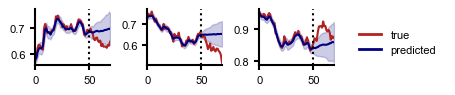

In [55]:
from matplotlib.lines import Line2D

with plt.rc_context(fname="../.matplotlibrc"):
    fig, axs = plt.subplots(1, n_traj+1, figsize=(1.2*n_traj+1, 1))
    for i, (true, mean, std) in enumerate(trajs):
        axs[i].plot(true, color="firebrick")
        axs[i].plot(mean, color="navy")
        axs[i].fill_between(np.arange(len(mean)), mean - 2 * std, mean + 2 * std, color="navy", alpha=0.2)
        axs[i].axvline(50, ymin=0, ymax=1, linestyle=":", color="black")
        axs[i].set_xlim(0, 69)
    axs[-1].axis('off')

    custom_lines = [Line2D([0], [0], color="firebrick", lw=2),
                    Line2D([0], [0], color="navy", lw=2)]
    plt.legend(custom_lines, ['true', 'predicted'], loc="lower right")
    plt.tight_layout()
    plt.savefig("temp.pdf")
    plt.show()

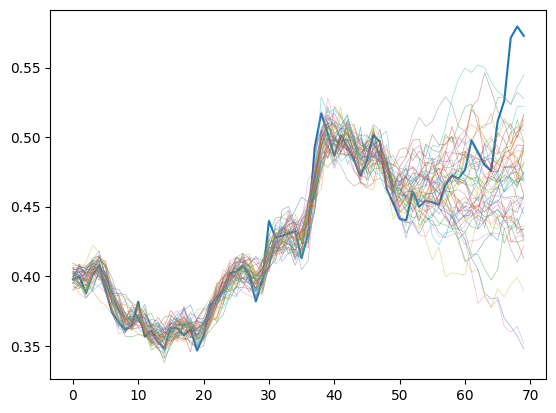

In [12]:
plt.plot(torch.cat([x[0, :, 0], y[0, :, 0]], dim=0).detach().cpu().numpy())
for traj in trajs:
    plt.plot(traj[:, :, 0], alpha=0.5, linewidth=0.5)

In [17]:
trajs[0].shape

(70, 1, 6)

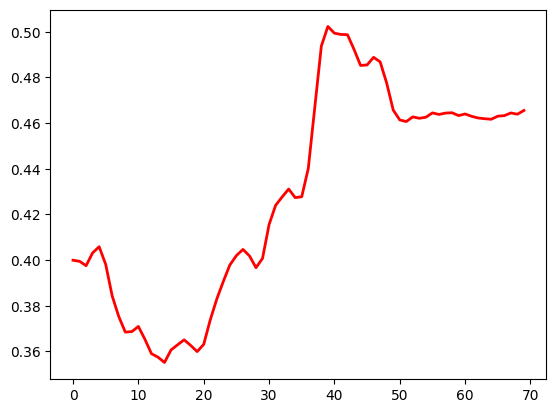

In [18]:
plt.plot(np.stack(trajs, axis=0).mean(axis=0)[:, 0, 0], color="red", linewidth=2)
